# Bulge Events and Observations

The goal of this notebook is to explore the number of Bulge events to be selected in the Key Project, and to estimate the observing time required. 

This estimate is based on the catalog of events alerted by OGLE & MOA from the Bulge extended survey region. 

In [205]:
from os import path
import csv
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
import h5py
from sys import path as pythonpath
pythonpath.append('../')
import healpixel_functions
import matplotlib.pyplot as plt

In [183]:
def read_ogle_catalog(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            s = SkyCoord(row[1], row[2], frame='icrs', unit=(u.hourangle, u.deg))
            mag = float(row[3])
            f_bl = float(row[4])
            if 'nan' in row[5]:
                te = np.NaN
            else:
                te = float(row[5])
            data.append([row[0], row[1], row[2], mag, f_bl, te, s])
    data = np.array(data)

    event_table = Table(
                        [Column(data=data[:,0], name='Event'),
                        Column(data=data[:,1], name='RA'),
                        Column(data=data[:,2], name='Dec'),
                        Column(data=data[:,3], name='Mag'),
                        Column(data=data[:,4], name='Blending'),
                        Column(data=data[:,5], name='tE'),
                        Column(data=data[:,6], name='Coordinate')]
                        )

    return event_table

OGLE and MOA survey overlapping regions of the sky and thereby tend to detect overlapping sets of events.  While MOA do detect some events that OGLE don't and vice versa, the OGLE catalog is more extensive, and more easily queried programmatically, so we use that as a representative sample for the basis of this estimate. 

In [184]:
event_file_path = 'ogle_event_data.csv'
bulge_events = read_ogle_catalog(event_file_path)
bulge_events

Event,RA,Dec,Mag,Blending,tE,Coordinate
object,object,object,object,object,object,object
OGLE-2002-BLG-001,17:51:16.16,-30:12:31.4,16.638,0.422,64.771,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.81733333, -30.20872222)>"
OGLE-2002-BLG-002,17:50:45.43,-30:04:13.9,17.692,1.0,49.107,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.68929167, -30.07052778)>"
OGLE-2002-BLG-003,17:54:25.85,-29:54:27.5,18.812,1.0,74.898,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.60770833, -29.90763889)>"
OGLE-2002-BLG-004,17:53:55.77,-29:53:32.0,17.424,0.267,102.431,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.482375, -29.89222222)>"
OGLE-2002-BLG-005,17:57:10.20,-29:43:41.8,18.576,1.0,30.081,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.2925, -29.72827778)>"
OGLE-2002-BLG-006,17:56:29.86,-29:26:27.5,18.542,1.0,51.621,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.12441667, -29.44097222)>"
...,...,...,...,...,...,...
OGLE-2019-BLG-1520,17:55:27.65,-29:03:54.8,19.67,1.0,27.725,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.86520833, -29.06522222)>"
OGLE-2019-BLG-1521,17:56:27.91,-30:31:37.9,16.633,1.0,10.138,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.11629167, -30.52719444)>"


However, we want to exclude events from the central Bulge region covered by KMTNet, so we read in the Bulge survey zone map, and filter the bulge_events list to include only those events from the region outside the central high cadence zone. 

In [185]:
NSIDE = 64

In [186]:
map_file_path = '../bulge_extended_zone_map.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

survey_region_map = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
survey_region_map

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
49146,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
49147,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


In [187]:
events_index = []
for ievent,event in enumerate(bulge_events):
    hpindex = healpixel_functions.skycoord_to_HPindex(event['Coordinate'], NSIDE)[0]
    if survey_region_map[hpindex]['Gamma'] > 0.0:
        events_index.append(ievent)

ext_zone_events = bulge_events[events_index]
ext_zone_events

Event,RA,Dec,Mag,Blending,tE,Coordinate
object,object,object,object,object,object,object
OGLE-2002-BLG-002,17:50:45.43,-30:04:13.9,17.692,1.0,49.107,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.68929167, -30.07052778)>"
OGLE-2002-BLG-010,17:49:10.73,-35:20:54.6,18.817,1.0,30.495,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.29470833, -35.3485)>"
OGLE-2002-BLG-011,17:55:30.87,-35:25:09.1,18.193,1.0,34.56,"<SkyCoord (ICRS): (ra, dec) in deg\n (268.878625, -35.41919444)>"
OGLE-2002-BLG-017,17:58:08.62,-34:18:21.7,19.123,1.0,14.975,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.53591667, -34.30602778)>"
OGLE-2002-BLG-018,18:01:08.82,-33:59:24.1,18.043,1.0,26.127,"<SkyCoord (ICRS): (ra, dec) in deg\n (270.28675, -33.99002778)>"
OGLE-2002-BLG-024,18:02:51.62,-33:39:59.7,19.129,1.0,27.585,"<SkyCoord (ICRS): (ra, dec) in deg\n (270.71508333, -33.66658333)>"
...,...,...,...,...,...,...
OGLE-2019-BLG-1479,17:51:56.31,-31:02:38.6,19.195,1.0,90.884,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.984625, -31.04405556)>"
OGLE-2019-BLG-1481,17:41:49.08,-35:01:10.8,20.223,0.512,31.6,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.4545, -35.01966667)>"


In [188]:
def count_events_per_year(event_set):
    events_per_year = {}
    for ievent,event in enumerate(event_set):
        name = str(event['Event'])
        year = name.split('-')[1]
        if year not in events_per_year.keys():
            events_per_year[year] = [ievent]
        else:
            events_per_year[year].append(ievent)

    for key, event_list in events_per_year.items():
        print(str(key)+': '+str(len(event_list))+' events')
    return events_per_year


How many events within the Bulge extended survey zone were detected each year?  It should be noted that OGLE is changing its observing strategy from 2023 and the OGLE team estimate that they will detected ~3000 events (OGLE, priv. comm.)

In [189]:
print('Events per year discovered in DR 14 data:')
events_per_year = count_events_per_year(ext_zone_events)

Events per year discovered in DR 14 data:
2002: 180 events
2003: 212 events
2004: 221 events
2005: 197 events
2006: 150 events
2007: 163 events
2008: 171 events
2009: 37 events
2011: 598 events
2012: 701 events
2013: 873 events
2014: 896 events
2015: 946 events
2016: 894 events
2017: 739 events
2018: 729 events
2019: 668 events


In [190]:
print('Long timescale events within the extended Bulge survey region per year:')
long_events = np.where(bulge_events['tE'] > 100.0)[0]
for year, event_list in events_per_year.items():
    long_event_year = list(set(long_events).intersection(set(event_list)))
    frac_long = float(len(long_event_year))/float(len(event_list))
    print(str(year)+': '+str(len(long_event_year))+' events, '+str(round(frac_long*100.0,2))+'%')
        

Long timescale events within the extended Bulge survey region per year:
2002: 8 events, 4.44%
2003: 6 events, 2.83%
2004: 13 events, 5.88%
2005: 6 events, 3.05%
2006: 7 events, 4.67%
2007: 1 events, 0.61%
2008: 3 events, 1.75%
2009: 0 events, 0.0%
2011: 24 events, 4.01%
2012: 38 events, 5.42%
2013: 36 events, 4.12%
2014: 55 events, 6.14%
2015: 29 events, 3.07%
2016: 62 events, 6.94%
2017: 22 events, 2.98%
2018: 54 events, 7.41%
2019: 27 events, 4.04%


Based on previous analysis of Bulge events by the RTmodel system for the 2019 season (the most recent season of survey operations undisrupted by the pandemic, https://www.fisica.unisa.it/GravitationAstrophysics/RTModel/2019/RTModel.htm), 8 planetary lens events were discovered from a total of 1526 (over the whole Bulge region), plus 40 stellar binary events.  This implies that 2.6% of events are binary, and 0.5% include planetary companions. Similar percentages are seen for other years.  

From the assessment above, we can also conservatively expect ~ 20 stellar remnant candidate events per year within the Bulge extended survey region, or ~ 2% of the events. 

**We therefore conservatively expect ~ 700 Bulge events to be detected in the extended Bulge region covered at low (~1-2 visits per day) survey cadence.  This implies that we can expect ~ 18 binary events plus 3-4 planetary events plus 20 long-timescale candidates per year in the extended survey zone.** 

In [191]:
n_extn_zone_events = 700 # per year
binary_frac = 2.6/100.0
planet_frac = 0.5/100.0
bh_frac = 2/100.0

n_binary_per_year = int(round((n_extn_zone_events * binary_frac),0))
n_planet_per_year = int(round((n_extn_zone_events * planet_frac),0))
n_bh_per_year = int(round((n_extn_zone_events * bh_frac),0))

print('Expect Bulge surveys to detect the following numbers of events per year in the Extended Survey Zone:')
print('N stellar binaries = '+str(n_binary_per_year))
print('N planet binaries = '+str(n_planet_per_year))
print('N BH = '+str(n_bh_per_year))


Expect Bulge surveys to detect the following numbers of events per year in the Extended Survey Zone:
N stellar binaries = 18
N planet binaries = 4
N BH = 14


Based on the kp_simulator simulation, LCO would be able to contribute follow-up observations for 42% of events discovered in the Bulge (largely limited by apparent magnitude for events, which suffer higher extinction than elsewhere in the sky). 


In [192]:
obs_frac = 0.4
n_years = 3

n_binary_obs_per_year = int(round((obs_frac * n_binary_per_year),0))
n_binary = n_binary_obs_per_year * n_years
n_planet_obs_per_year = int(round((obs_frac * n_planet_per_year),0))
n_planet = n_planet_obs_per_year * n_years
n_bh_obs_per_year = int(round((obs_frac * n_bh_per_year),0))
n_bh = n_bh_obs_per_year * n_years

print('Expect LCO to be able to observe the following numbers of events in the Extended Survey Zone:')
print('N stellar binaries = '+str(n_binary_obs_per_year)+' per year, and '+str(n_binary)+' in total')
print('N planetary binaries = '+str(n_planet_obs_per_year)+' per year, and '+str(n_planet)+' in total')
print('N stellar remnants = '+str(n_bh_obs_per_year)+' per year, and '+str(n_bh)+' in total')


Expect LCO to be able to observe the following numbers of events in the Extended Survey Zone:
N stellar binaries = 7 per year, and 21 in total
N planetary binaries = 2 per year, and 6 in total
N stellar remnants = 6 per year, and 18 in total


## Observing Time Required for Bulge Event Follow-up

We can use the simulated data products of the Key Project observing strategy to estimate the total time required to observe Bulge events. 

In [193]:
def read_sim_event_table(file_path):
    hdul = fits.open(file_path)
    cols = hdul[1].columns
    data = hdul[1].data
    column_list = []
    for col in cols:
        if col.name == 'EventID':
            dtype = 'str'
        elif col.name in ['HEALpixel', 'nvisits']:
            dtype = 'int'
        else:
            dtype = 'float'
        column_list.append(Column(name=col.name, data=data[col.name], dtype=dtype))
    
    return Table(column_list)

In [194]:
def read_lco_sim_data(file_path, n_events):
    f = h5py.File(file_path, "r")
    dataset = {}
    for eventid in f.keys():
        dataset[eventid] = f[eventid][:]
    
    return dataset

In [195]:
sim_lco_lc_file = '../simulated_lco_lightcurves_bulge_events.hdf5'
dataset = read_lco_sim_data(sim_lco_lc_file, 1000)

In [196]:
sim_data_file = '../sim_bulge_events_table.fits'
events_table = read_sim_event_table(sim_data_file)

In [197]:
events_table

EventID,HEALpixel,RA_deg,Dec_deg,baseline_mag,blend_ratio,t0,u0,tE,rho,piEN,piEE,nvisits,binary_lens
str14,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
BulgeSim00001,39232,270.0,-36.4235725402832,17.908000946044922,0.7799999713897705,2460348.0,-0.07430554926395416,16.68768310546875,0.01901441067457199,0.6830319762229919,0.24638403952121735,1846,0.0
BulgeSim00002,37187,274.21875,-30.691585540771484,17.408000946044922,0.029999999329447746,2460936.5,0.11208660155534744,24.460752487182617,0.0033516644034534693,0.8797856569290161,-0.2112245410680771,1846,0.0
BulgeSim00003,34116,275.625,-22.66960906982422,19.908000946044922,0.029999999329447746,2461045.75,0.6554144024848938,17.110116958618164,0.011044623330235481,-0.7181605100631714,0.04251528158783913,1846,0.0
BulgeSim00004,37185,271.40625,-30.691585540771484,19.658000946044922,0.7799999713897705,2460445.5,0.6014909148216248,10.126562118530273,0.0006753820343874395,-0.3732929825782776,-0.5256137251853943,1846,0.0
BulgeSim00005,38211,274.21875,-33.51005554199219,19.908000946044922,0.029999999329447746,2461179.25,0.16531983017921448,90.64039611816406,0.003346493234857917,1.572751522064209,-0.24887365102767944,1846,0.0
BulgeSim00006,34365,266.484375,-23.317955017089844,19.408000946044922,0.7799999713897705,2460166.25,-0.23179543018341064,7.954485893249512,0.025362001731991768,-0.19389182329177856,-0.03340071812272072,1846,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
BulgeSim00994,38974,267.890625,-35.685333251953125,20.408000946044922,0.7799999713897705,2460549.25,0.1489478051662445,54.63604736328125,0.0031426141504198313,0.843697190284729,0.009371805936098099,1846,0.0
BulgeSim00995,33087,268.59375,-20.10550880432129,19.908000946044922,0.029999999329447746,2460483.0,0.6646540760993958,29.92071533203125,0.0008718562312424183,-0.2620587944984436,0.13978320360183716,1846,0.0


We can use the simulated LCO lightcurves produced by the Key Project observing strategy, to estimate the typical number of visits to target that we can expect.  We can also use the same data to estimate the total exposure time per target, since the simulation includes target brightness as a function of time.  In order to estimate realistic exposure times on LCO 1m telescopes for targets at these magnitudes, we use the following empirical function, which was derived from previous LCO 1m photometry. 

In [198]:
def ETC(magin):
    """
    This function calculates the required exposure time
    for a given iband magnitude (e.g. OGLE I which also
    roughly matches SDSS i) based on a fit to the empiric
    LCO photometry.  Adapted from code by Markus Hundertmark.
    """
    
    mag = np.zeros(len(magin))
    mag[:] = magin
    
    # Cap the exposures at the bright end to minimise scintillation noise (min 5s)
    idx = np.where(magin < 14.7)
    mag[idx] = 14.7

    lrms = 0.14075464 * mag * mag - 4.00137342 * mag + 24.17513298
    snr = 1.0 / np.exp(lrms)

    # target 4% -> snr 25
    exptime = np.round((25. / snr)**2 * 300.,1)
    
    #Avoid exposures longer than 5min:
    idx = np.where(exptime > 300.0)
    exptime[idx] = 300.0

    return  exptime

In addition to the open-shutter time required during each visit to target, we need to account for telescope slew, instrument readout etc.  Based on the LCO instrumentation website (https://lco.global/observatory/instruments/), the overheads per frame for the LCO 1m Sinistro cameras is 28s.  So we add this to each exposure. 

In [207]:
def estimate_obs_time(event_set, events_table, dataset, nobs_cut=False):
    
    lco_obs_time = []
    lco_nvisits = []
    
    for ievent in event_set:
        event_name = events_table[ievent]['EventID']
        lco_lc = dataset[event_name]
        
        # Include only events that have been well studied
        accept = True
        if nobs_cut: 
            accept = False
            if len(lco_lc) > 100:
                accept = True
        
        if accept:
            lco_nvisits.append(len(lco_lc))

            # Calculate the exposure time per visit based on the target magnitude at the time, then 
            # add the instrumental overheads
            if len(lco_lc) > 0:
                lco_exposures = ETC(lco_lc[:,1])
                lco_exposures += 28.0
            else:
                lco_exposures = np.zeros(1)

            lco_obs_time.append(lco_exposures.sum())
        
    lco_nvisits = np.array(lco_nvisits)
    lco_obs_time = np.array(lco_obs_time)/3600.0

    return lco_nvisits, lco_obs_time


In [208]:
# Get the table indices of events in different categories. 
bh_events = np.where(events_table['tE'] > 100.0)[0]
stellar_events = np.where(events_table['tE'] < 100.0)[0]

In [209]:
# Get indices of the events where observations were possible
lco_data_count = []
for ievent in range(0,len(events_table),1):
    event_name = events_table[ievent]['EventID']
    lco_lc = dataset[event_name]
    lco_data_count.append(len(lco_lc))
lco_data_count = np.array(lco_data_count)
observed_events = np.where(lco_data_count > 10)[0]

In [210]:
# Get indices of observed events in different categories
bh_events = list(set(bh_events).intersection(set(observed_events)))
stellar_events = list(set(stellar_events).intersection(set(observed_events)))

Median number of LCO visits per event: 492.5 for 828 events
Median total LCO exposure time per event: 23.728833333333334hrs
Mean number of LCO visits per event: 3705.735294117647 for 828 events
Mean total LCO exposure time per event: 196.31221793300654hrs


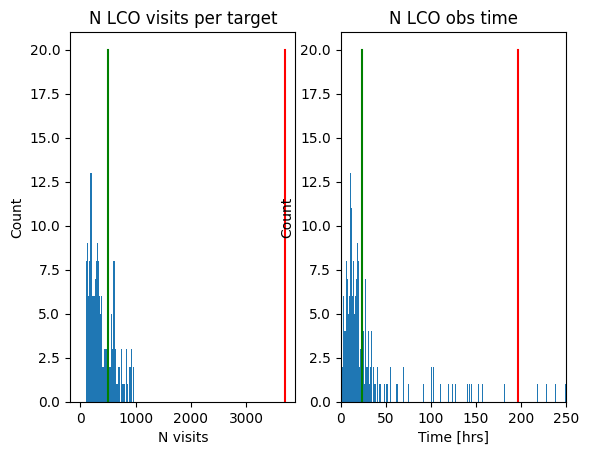

In [214]:
# Get the table indices of stellar events
#stellar_events = np.where(events_table['tE'] < 100.0)[0]
stellar_lenses = np.where(events_table['tE'] < 100.0)[0]
single_lenses = np.where(events_table['binary_lens'] == 0)[0]
single_stellar_lenses = list(set(stellar_lenses).intersection(set(single_lenses)))


# Estimate the number of visits per target and observing time required:
(lco_nvisits, lco_obs_time) = estimate_obs_time(single_stellar_lenses, events_table, dataset, nobs_cut=True)

fig, axs = plt.subplots(1, 2)
axs[0].hist(lco_nvisits, bins=np.arange(0, 1000 ,20))
axs[0].set_title('N LCO visits per target')
axs[0].set_xlabel('N visits')
axs[0].set_ylabel('Count')
#axs[0].set_xlim([0,1000])
axs[1].hist(lco_obs_time, bins=np.arange(0, lco_obs_time.max(),1))
axs[1].set_title('N LCO obs time')
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Count')
axs[1].set_xlim([0,250])

time_per_single_lens = np.median(lco_obs_time)
avg_time_per_single_lens = lco_obs_time.mean()
visits_per_single_lens = np.median(lco_nvisits)
avg_visits_per_single_lens = lco_nvisits.mean()

axs[0].plot([visits_per_single_lens,visits_per_single_lens],
            [0,20], 'g-')
axs[0].plot([avg_visits_per_single_lens,avg_visits_per_single_lens],
            [0,20], 'r-')
axs[1].plot([time_per_single_lens,time_per_single_lens],
            [0,20], 'g-')
axs[1].plot([avg_time_per_single_lens,avg_time_per_single_lens],
            [0,20], 'r-')

print('Median number of LCO visits per event: '+str(np.median(lco_nvisits))+' for '+str(len(single_stellar_lenses))+' events')
print('Median total LCO exposure time per event: '+str(time_per_single_lens)+'hrs')

print('Mean number of LCO visits per event: '+str(avg_visits_per_single_lens)+' for '+str(len(single_stellar_lenses))+' events')
print('Mean total LCO exposure time per event: '+str(avg_time_per_single_lens)+'hrs')



Median number of LCO visits per event: 496.0 for 85 events
Median total LCO exposure time per event: 26.810833333333335hrs
Mean number of LCO visits per event: 471.35714285714283 for 85 events
Mean total LCO exposure time per event: 26.445060515873017hrs


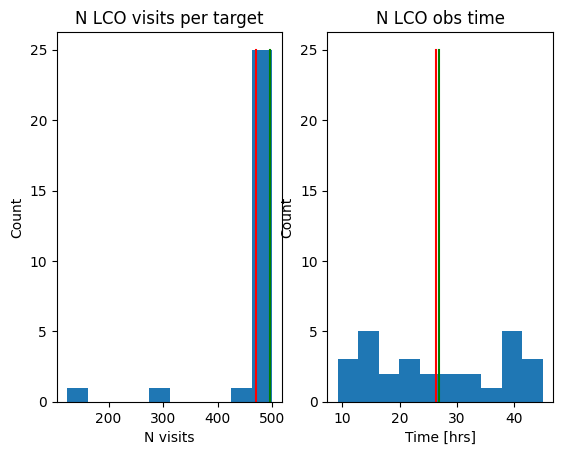

In [216]:
# Get the table indices of long-duration events
bh_events = np.where(events_table['tE'] > 100.0)[0]

# Estimate the number of visits per target and observing time required:
(lco_nvisits_bh, lco_obs_time_bh) = estimate_obs_time(bh_events, events_table, dataset, nobs_cut=True)

fig, axs = plt.subplots(1, 2)
axs[0].hist(lco_nvisits_bh)
axs[0].set_title('N LCO visits per target')
axs[0].set_xlabel('N visits')
axs[0].set_ylabel('Count')
#axs[0].set_xlim([0,1000])
axs[1].hist(lco_obs_time_bh)
axs[1].set_title('N LCO obs time')
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Count')

time_per_bh_lens = np.median(lco_obs_time_bh)
avg_time_per_bh_lens = lco_obs_time_bh.mean()
visits_per_bh_lens = np.median(lco_nvisits_bh)
avg_visits_per_bh_lens = lco_nvisits_bh.mean()

axs[0].plot([visits_per_bh_lens,visits_per_bh_lens],
            [0,25], 'g-')
axs[0].plot([avg_visits_per_bh_lens,avg_visits_per_bh_lens],
            [0,25], 'r-')
axs[1].plot([time_per_bh_lens,time_per_bh_lens],
            [0,25], 'g-')
axs[1].plot([avg_time_per_bh_lens,avg_time_per_bh_lens],
            [0,25], 'r-')

print('Median number of LCO visits per event: '+str(visits_per_bh_lens)+' for '+str(len(bh_events))+' events')
print('Median total LCO exposure time per event: '+str(time_per_bh_lens)+'hrs')

print('Mean number of LCO visits per event: '+str(avg_visits_per_bh_lens)+' for '+str(len(bh_events))+' events')
print('Mean total LCO exposure time per event: '+str(avg_time_per_bh_lens)+'hrs')



Median number of LCO visits per event: 289.0 for 87 events
Median total LCO exposure time per event: 21.078944444444442hrs
Mean number of LCO visits per event: 1635.8484848484848 for 87 events
Mean total LCO exposure time per event: 125.05659932659933hrs


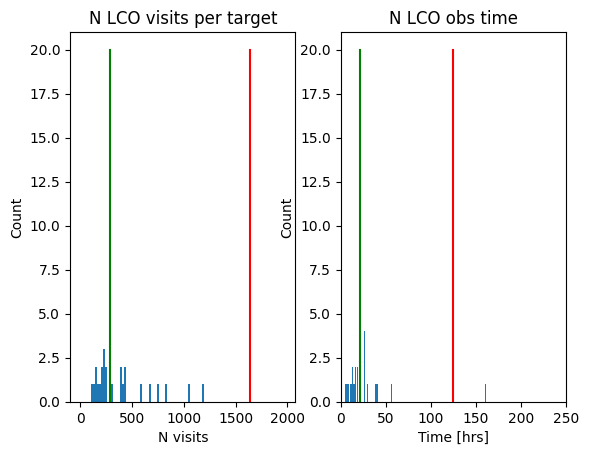

In [221]:
# Get the table indices of binary-lens stellar events
stellar_lenses = np.where(events_table['tE'] < 100.0)[0]
binary_lenses = np.where(events_table['binary_lens'] == 1)[0]
binary_stellar_lenses = list(set(stellar_lenses).intersection(set(binary_lenses)))

# Estimate the number of visits per target and observing time required:
(lco_nvisits_binary, lco_obs_time_binary) = estimate_obs_time(binary_stellar_lenses, events_table, dataset, nobs_cut=True)

fig, axs = plt.subplots(1, 2)
axs[0].hist(lco_nvisits_binary, bins=np.arange(0, 2000 ,20))
axs[0].set_title('N LCO visits per target')
axs[0].set_xlabel('N visits')
axs[0].set_ylabel('Count')
#axs[0].set_xlim([0,2000])
axs[1].hist(lco_obs_time_binary, bins=np.arange(0, lco_obs_time_binary.max(),1))
axs[1].set_title('N LCO obs time')
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Count')
axs[1].set_xlim([0,250])

time_per_binary_lens = np.median(lco_obs_time_binary)
avg_time_per_binary_lens = lco_obs_time_binary.mean()
visits_per_binary_lens = np.median(lco_nvisits_binary)
avg_visits_per_binary_lens = lco_nvisits_binary.mean()

axs[0].plot([visits_per_binary_lens,visits_per_binary_lens],
            [0,20], 'g-')
axs[0].plot([avg_visits_per_binary_lens,avg_visits_per_binary_lens],
            [0,20], 'r-')
axs[1].plot([time_per_binary_lens,time_per_binary_lens],
            [0,20], 'g-')
axs[1].plot([avg_time_per_binary_lens,avg_time_per_binary_lens],
            [0,20], 'r-')

print('Median number of LCO visits per event: '+str(visits_per_binary_lens)+' for '+str(len(binary_stellar_lenses))+' events')
print('Median total LCO exposure time per event: '+str(time_per_binary_lens)+'hrs')

print('Mean number of LCO visits per event: '+str(avg_visits_per_binary_lens)+' for '+str(len(binary_stellar_lenses))+' events')
print('Mean total LCO exposure time per event: '+str(avg_time_per_binary_lens)+'hrs')



In [173]:
total_time_bh_events = n_bh * time_per_bh_event
print('The expected sample of '+str(n_bh)+' long-duration events is therefore estimated to required a total of '+str(round(total_time_bh_events,0))+'hrs')

total_time_stellar_events = n_binary * time_per_stellar_event
print('The expected sample of '+str(n_binary)+' stellar events is therefore estimated to required a total of '+str(round(total_time_stellar_events,0))+'hrs')

total_time_planet_events = n_planet * time_per_stellar_event
print('The expected sample of '+str(n_planet)+' planetary events is therefore estimated to required a total of '+str(round(total_time_planet_events,0))+'hrs')



The expected sample of 18 long-duration events is therefore estimated to required a total of 328.0hrs
The expected sample of 21 stellar events is therefore estimated to required a total of 379.0hrs
The expected sample of 6 planetary events is therefore estimated to required a total of 108.0hrs


All stellar and planetary binary lens events are allocated an additional 12hrs of high-cadence (every 15min) observations on top of the regular monitoring.

In [174]:
add_time_binary_events = (n_binary + n_planet) * 12.0
print('The '+str(n_binary + n_planet)+' binary events are estimated to require an additional '+str(round(add_time_binary_events,0))+'hrs')



The 27 binary events are estimated to require an additional 324.0hrs


In [175]:
total_time = total_time_bh_events + total_time_stellar_events + total_time_planet_events + add_time_binary_events
time_bh_planet = total_time_bh_events + total_time_planet_events
print('In total, LCO observations of all Bulge targets would be expected to require: '+str(total_time)+'hrs')
print('Total time required for stellar remnant and planetary candidates only '+str(time_bh_planet)+'hrs')

In total, LCO observations of all Bulge targets would be expected to require: 1138.7735000000002hrs
Total time required for stellar remnant and planetary candidates only 435.8261666666667hrs


## Observations from the 2m Network and Rapid Response Observations

The 2m network offers the MusCAT multi-channel imagers and the FLOYDS spectrographs.  

While only a few targets will be accessible to FLOYDS (r<15mag), the spectra are extremely useful to constrain the source star parameters for all categories of microlensing event.  In order to distinguish the source star spectrum from neighboring objects, spectra at multiple epochs with different lensing magnifications are required, though not at the high cadence required for photometry.  We propose to obtain 3 spectra of selected targets that reach magnitudes brighter than 15mag (where FLOYDS can deliver S/N=100 in 1hr of exposure).  

We can estimate the potential number of FLOYDS targets using the simulated LCO lightcurve dataset, and identifing the fraction of targets likely to exceed 15mag.  

In [176]:
sim_survey_lc_file = '../simulated_bulge_lightcurves.hdf5'
survey_dataset = read_lco_sim_data(sim_survey_lc_file, 1000)

In [178]:
bright_events = []
n_survey_lc = 0
for ievent in range(0,len(survey_dataset),1):
    event_name = events_table[ievent]['EventID']
    
    survey_lc = dataset[event_name]
    if len(survey_lc) > 0:
        n_survey_lc += 1
        idx = np.where(survey_lc[:,1] < 15.0)[0]
        if len(idx) > 0:
            bright_events.append(ievent)

frac_bright_events = float(len(bright_events))/float(len(events_table))
print('Fraction of events accessible to FLOYDS = '+str(frac_bright_events))
print('Number of full survey lightcurve '+str(n_survey_lc))

Fraction of events accessible to FLOYDS = 0.121
Number of full survey lightcurve 411


Since there is a FLOYDS spectrograph in both hemispheres, the 2m network can observe any target while it is visible to our target surveys.  Of the (8 stellar + 2 planetary + 8 BH) = 18 Bulge targets we expect per year we expect to be able to observe ~ 2 with FLOYDS.  

Each FLOYDS observation will consist of a 1hr science exposure plus the LCO-recommended set of calibration exposures: 2x60s arc frames with the HgAr and Zn lamps for wavelength calibration and 2x70s flat field exposures with the Tungsten-Halogen + Xenon lamp, since we will use the 1.2" slit due to the crowding in this field.  Calibration frames will be requested both before and after each science spectrum.  

Following the overhead calculation recommended on the FLOYDS website for a 1hr science spectrum:
Initial setup and telescope slew is 120 s. 
Target acquisition is 90 s. 
Lamp flat exposures include an overhead of 60 s.
Arc lamp exposures include an overhead of 100 s. 
All configuration changes (from flat to arc to science spectrum) require a 16 s software setup overhead. 
Readout time is 26 s. 

In [179]:
# All times in s
tel_slew = 120.0
target_acquisition = 90.0
lamp_exp_overhead = 60.0
lamp_exp = 70.0
arc_exp_overhead = 100.0
arc_exp = 60.0
software = 16.0
readout = 26.0
science_exp = 3600.0

In [180]:
time_per_FLOYDS_visit = tel_slew + target_acquisition \
                    + lamp_exp_overhead + software + lamp_exp + readout \
                    + arc_exp_overhead + software + arc_exp + readout \
                    + software + science_exp + readout \
                    + lamp_exp_overhead + software + lamp_exp + readout \
                    + arc_exp_overhead + software + arc_exp + readout
time_per_FLOYDS_visit /= 60.0

print('Time required per FLOYDS visit to 1 target = '+str(time_per_FLOYDS_visit)+'min')

Time required per FLOYDS visit to 1 target = 76.66666666666667min


Taking 3 visits per FLOYDS target therefore requires a total request of (split 50:50 North/South):

In [181]:
n_FLOYDS_targets = 2
time_FLOYDS_year = n_FLOYDS_targets * time_per_FLOYDS_visit * 3.0
total_FLOYDS_time = 3*time_FLOYDS_year
time_FLOYDS_year /= 60.0
total_FLOYDS_time /= 60.0

print('Total time required on FLOYDS per year = '+str(time_FLOYDS_year)+'hrs')
print('Total time = '+str(total_FLOYDS_time)+'hrs')

Total time required on FLOYDS per year = 7.666666666666667hrs
Total time = 23.0hrs


The MuSCAT four-channel imagers are particularly important for binary lens events, as they can deliver high-cadence multi-color observations of caustic crossings and planetary anomalies, short-lived, sharp discontinuities in the lightcurves.  Planetary anomalies typically last a few hours.  The sharp discontinuities that mark the entrance and exits of caustic crossings are of similar timescale.  In both cases, it is extremely important to monitor their photometry continuously for that period in order to constrain the morphology of the lightcurve, which in turn constrains the models of the caustic structure and lens-source relative trajectory.  

While almost all of the observations from this program can be made in queue-scheduled mode, the short timescale and transient nature of these features require rapid response time to ensure that we can observe as soon as they are detected by our real-time modeling system.  They also justify observing from every site in the network to ensure as continuous coverage as possible.  For this reason, we request the following time on MuSCAT and some 1m time is allocated in Rapid Response mode.

Anomalies and caustic crossings are only seen in the stellar and planetary binary events we expect from the Bulge survey.  Adopting an average duration of 4hrs for a planetary anomaly and 6hrs per caustic entrance and exit (i.e. 12hrs per target), we request in Rapid Response mode:

2 planetary candidates/year * 4hrs = 8hrs per year
2x6hrs * 8 binary candidates/year = 96hrs per year
Total = 104hrs per year 

For Bulge targets, FTS can observe up to 8hrs per night (UTC ~ 8-16hrs) while FTN can observe for up to ~ 4hrs (between UTC 6-10hrs).  Since these ranges overlap, their combined maximal visibility period is up to ~ 10hrs out of 24hr or a fraction of 0.42.  

We therefore request 0.42x104hrs/yr on the 2m network = 43hrs/yr on the 2m MusCAT imagers, and the remainder (61hrs/yr) on the 1m network. 

In [134]:
# Planetary candidates
n_planet_targets = 2
hrs_obs = 4.0
vis_frac = 0.42
muscat_hrs_per_year_planets = n_planet_targets * hrs_obs * vis_frac
muscat_total_hrs_planets = 3.0 * muscat_hrs_per_year_planets
print('MuSCAT time required for planetary targets per year = '+str(muscat_hrs_per_year_planets)+'hrs')
print('Total MuSCAT time required for planetary targets = '+str(muscat_total_hrs_planets)+'hrs')

MuSCAT time required for planetary targets per year = 3.36hrs
Total MuSCAT time required for planetary targets = 10.08hrs


In [135]:
# Stellar binary candidates
n_stellar_targets = 8
hrs_obs = 2*6.0
vis_frac = 0.42
muscat_hrs_per_year_stellar = n_stellar_targets * hrs_obs * vis_frac
muscat_total_hrs_stellar = 3.0 * muscat_hrs_per_year_stellar
print('MuSCAT time required for stellar binary targets per year = '+str(muscat_hrs_per_year_stellar)+'hrs')
print('Total MuSCAT time required for stellar binary targets = '+str(muscat_total_hrs_stellar)+'hrs')

MuSCAT time required for stellar binary targets per year = 40.32hrs
Total MuSCAT time required for stellar binary targets = 120.96000000000001hrs
